In [1]:
import pandas as pd
import numpy as np
import torch
import os
import torch.nn as nn
from dotenv import load_dotenv
import umap.umap_ as umap
import matplotlib.pyplot as plt
load_dotenv()

c:\Users\Evint\Documents\Projects\Functional-Group-Analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class ClassicAutoencoder(nn.Module):
    """Classic Autoencoder with ReLU activations."""

    def __init__(self, input_size, hidden_sizes):
        super(ClassicAutoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                encoder_layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                encoder_layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            encoder_layers.append(nn.ReLU())  # Add ReLU after each linear layer
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        for i in range(len(hidden_sizes) - 1, -1, -1):
            if i == 0:
                decoder_layers.append(nn.Linear(hidden_sizes[i], input_size))
            else:
                decoder_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i - 1]))
                decoder_layers.append(nn.ReLU())  # Add ReLU after each linear layer except the final output
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [3]:
encoder_model = ClassicAutoencoder(28, eval(os.getenv("AUTOENCODER_HIDDEN_SIZE")))
encoder_model.load_state_dict(torch.load(os.getenv('AUTOENCODER_MODEL_PATH')))
encoder_model.eval()

ClassicAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=28, bias=True)
  )
)

In [4]:
df = pd.read_csv(os.getenv("TRAIN_DATASET_PATH")).drop("label", axis=1)
X = df.values

In [5]:
tensor_X = torch.tensor(X).float()
encoded = encoder_model.encoder(tensor_X)
numpy_encoded = encoded.detach().numpy()

In [12]:
# Configure the UMA model
uma_model = umap.UMAP()
# Fit and transform the data
X_embedded = uma_model.fit_transform(X)

c:\Users\Evint\Documents\Projects\Functional-Group-Analysis\venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [13]:
X_embedded

array([[ 2.0845299 , -3.7281017 ],
       [ 9.248716  , -6.1580777 ],
       [-3.4830644 , -0.5865977 ],
       ...,
       [13.788162  ,  9.8277    ],
       [19.122215  ,  7.5589004 ],
       [ 1.3985072 ,  0.41469502]], dtype=float32)

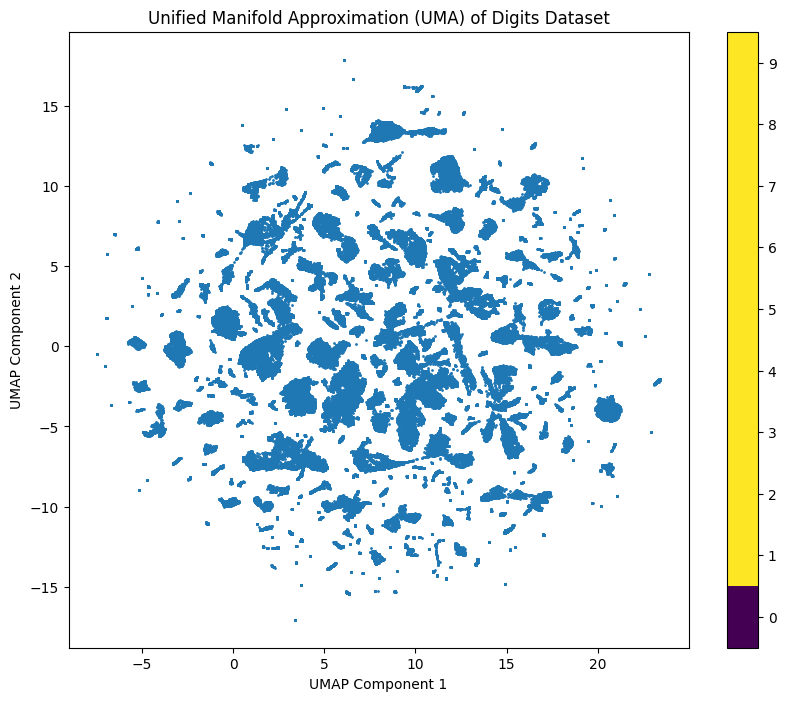

In [14]:
# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)
plt.colorbar(scatter, boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Unified Manifold Approximation (UMA) of Digits Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()